In [1]:
!pip install -q transformers seqeval

In [2]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 77.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 124.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 674.2/674.2 kB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 36.7 MB/s eta 0:00:0000:0100:01


In [3]:
import easyocr
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [4]:
def convert_to_min_max(bbox_points):
    x_values = [point[0] for point in bbox_points]
    y_values = [point[1] for point in bbox_points]

    x_min = min(x_values)
    y_min = min(y_values)
    x_max = max(x_values)
    y_max = max(y_values)

    return [x_min, y_min, x_max, y_max]

In [5]:
result = reader.readtext('training_data/images/1.jpg')
# print(result)

words = []
bounding_boxes = []
labels = []
for (bbox, text, prob) in result:
    words.append(text)
    converted_bbox = convert_to_min_max(bbox)
    bounding_boxes.append(converted_bbox)
    labels.append('DOB')
    print(f'Text: {text}, Probability: {prob}, Bbox: {bbox}')
print(words)
print(bounding_boxes)
print(labels)

Text: IG HFR, Probability: 0.18137036409660745, Bbox: [[208, 12], [267, 12], [267, 30], [208, 30]]
Text: GOVERNMENT OF NEPAL, Probability: 0.9481064254748501, Bbox: [[165, 29], [317, 29], [317, 43], [165, 43]]
Text: tart 917$ 3a, Probability: 0.029366899039132338, Bbox: [[178, 41], [304, 41], [304, 67], [178, 67]]
Text: DLNo:: 01-08-00355577, Probability: 0.7495563983713253, Bbox: [[21, 65], [151, 65], [151, 79], [21, 79]]
Text: DRIVING LICENSE, Probability: 0.7459982639422116, Bbox: [[179, 59], [303, 59], [303, 79], [179, 79]]
Text: BG: 0t, Probability: 0.7589048794628076, Bbox: [[21, 87], [67, 87], [67, 99], [21, 99]]
Text: Name:, Probability: 0.745998290019124, Bbox: [[170, 86], [202, 86], [202, 94], [170, 94]]
Text: Yubraj Khanal, Probability: 0.8948336673203274, Bbox: [[207, 85], [291, 85], [291, 99], [207, 99]]
Text: Address: Amarapuri-06,Nawalparasi, Probability: 0.9275578219183678, Bbox: [[169, 104], [369, 104], [369, 122], [169, 122]]
Text: Kmh, Probability: 0.1665817052125930

In [6]:
labels = ['B-Name','I-Name', 'B-DOB','I-DOB', 'B-LiscenseNo', 'I-LiscenseNo', 'B-Text', 'I-Text']
labels

['B-Name',
 'I-Name',
 'B-DOB',
 'I-DOB',
 'B-LiscenseNo',
 'I-LiscenseNo',
 'B-Text',
 'I-Text']

In [7]:
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'B-Name': 0,
 'I-Name': 1,
 'B-DOB': 2,
 'I-DOB': 3,
 'B-LiscenseNo': 4,
 'I-LiscenseNo': 5,
 'B-Text': 6,
 'I-Text': 7}

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [9]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import numpy as np
from torchvision.transforms import ToTensor
import torch
import os

In [10]:
def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]
    
def resize_and_align_bounding_box(bbox, original_image, target_size):
  x_, y_ = original_image.size

  x_scale = target_size / x_ 
  y_scale = target_size / y_
  
  origLeft, origTop, origRight, origBottom = tuple(bbox)
  
  x = int(np.round(origLeft * x_scale))
  y = int(np.round(origTop * y_scale))
  xmax = int(np.round(origRight * x_scale))
  ymax = int(np.round(origBottom * y_scale)) 
  
  return [x-0.5, y-0.5, xmax+0.5, ymax+0.5]

In [11]:
class OcrDataset(Dataset):
    def __init__(self, image_file_names, tokenizer, max_length, target_size):
        self.image_file_names = image_file_names
        self.tokenizer = tokenizer
        self.max_seq_length = max_length
        self.target_size = target_size
        self.pad_token_box = [0, 0, 0, 0]
        
        
    def __len__(self):
        return len(self.image_file_names)
    
    def __getitem__(self, idx):
        item = self.image_file_names[idx]
        base_path = f"{os.getcwd()}/testing_data"
        
        
        original_image = Image.open(base_path + "/images/" + item).convert("RGB")
        resized_image = original_image.resize((self.target_size, self.target_size))
        
        result = reader.readtext(base_path + "/images/" + item)
        
        words = []
        unnormalized_word_boxes = []
        word_labels = []
        
        for (bbox, text, prob) in result:
            words.append(text)
            converted_bbox = convert_to_min_max(bbox)
            unnormalized_word_boxes.append(converted_bbox)
            word_labels.append('DOB')
            # print(f'Text: {text}, Probability: {prob}, Bbox: {bbox}')
        
        
            
        width, height = original_image.size
        normalized_word_boxes = [normalize_box(bbox, width, height) for bbox in unnormalized_word_boxes]
        assert len(words) == len(normalized_word_boxes)
        
        token_boxes = []
        unnormalized_token_boxes = []
        token_labels = []
        for word, unnormalized_box, box, label in zip(words, unnormalized_word_boxes, normalized_word_boxes, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            unnormalized_token_boxes.extend(unnormalized_box for _ in range(len(word_tokens)))
            token_boxes.extend(box for _ in range(len(word_tokens)))
            
            for i in range(len(word_tokens)):
                if i == 0:
                    token_labels.extend(['B-' + label])
                else:
                    token_labels.extend(['I-' + label])
                    
        special_tokens_count = 2
        if len(token_boxes) > self.max_seq_length - special_tokens_count:
            token_boxes = token_boxes[: (self.max_seq_length - special_tokens_count)]
            unnormalized_token_boxes = unnormalized_token_boxes[: (self.max_seq_length - special_tokens_count)]
            token_labels = token_labels[: (self.max_seq_length - special_tokens_count)]
        
        token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
        unnormalized_token_boxes = [[0, 0, 0, 0]] + unnormalized_token_boxes + [[1000, 1000, 1000, 1000]]
        token_labels = [-100] + token_labels + [-100]
        
        encoding = self.tokenizer(' '.join(words), padding='max_length', truncation=True)
        
        input_ids = self.tokenizer(' '.join(words), truncation=True)["input_ids"]
        padding_length = self.max_seq_length - len(input_ids)
        token_boxes += [self.pad_token_box] * padding_length
        unnormalized_token_boxes += [self.pad_token_box] * padding_length
        token_labels += [-100] * padding_length
        encoding['bbox'] = token_boxes
        encoding['labels'] = token_labels
        
        assert len(encoding['input_ids']) == self.max_seq_length
        assert len(encoding['attention_mask']) == self.max_seq_length
        assert len(encoding['token_type_ids']) == self.max_seq_length
        assert len(encoding['bbox']) == self.max_seq_length
        assert len(encoding['labels']) == self.max_seq_length
        
        encoding['resized_image'] = ToTensor()(resized_image)
        encoding['resized_and_aligned_bounding_boxes'] = [resize_and_align_bounding_box(bbox, original_image, self.target_size) 
                                                          for bbox in unnormalized_token_boxes]
        
        encoding['unnormalized_token_boxes'] = unnormalized_token_boxes
        
        for k,v in encoding.items():
            if k == 'labels':
              label_indices = []
              # convert labels from string to indices
              for label in encoding[k]:
                if label != -100:
                  label_indices.append(label2idx[label])
                else:
                  label_indices.append(label)
              encoding[k] = label_indices
            encoding[k] = torch.as_tensor(encoding[k])
            
        return encoding

In [12]:
class DocDataset(Dataset):
    def __init__(self, image_file_names, tokenizer, max_length, target_size, train=True):
        self.image_file_names = image_file_names
        self.tokenizer = tokenizer
        self.max_seq_length = max_length
        self.target_size = target_size
        self.pad_token_box = [0, 0, 0, 0]
        self.train = train
        
    def __len__(self):
        return len(self.image_file_names)
    
    def __getitem__(self, idx):
        item = self.image_file_names[idx]
        if self.train:
          base_path = f"{os.getcwd()}/training_data"
        else:
          base_path = f"{os.getcwd()}/testing_data"
        
        original_image = Image.open(base_path + "/images/" + item).convert("RGB")
        resized_image = original_image.resize((self.target_size, self.target_size))
        
        with open(base_path + '/annotations/' + item[:-4] + '.json') as f:
            data = json.load(f)
        words = []
        unnormalized_word_boxes = []
        word_labels = []
        
        for label in data['label']:
            unnormalized_word_boxes.append([label["x"] * label["original_width"] / 100, label["y"] * label["original_height"] / 100, (label["x"] + label["width"]) * label["original_width"] / 100, (label["y"] + label["height"]) * label["original_height"] / 100])
            word_labels.append(label["labels"][0])

        for transcription in data['transcription']:
            words.append(transcription)
            
        width, height = original_image.size
        normalized_word_boxes = [normalize_box(bbox, width, height) for bbox in unnormalized_word_boxes]
        assert len(words) == len(normalized_word_boxes)
        
        token_boxes = []
        unnormalized_token_boxes = []
        token_labels = []
        for word, unnormalized_box, box, label in zip(words, unnormalized_word_boxes, normalized_word_boxes, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            unnormalized_token_boxes.extend(unnormalized_box for _ in range(len(word_tokens)))
            token_boxes.extend(box for _ in range(len(word_tokens)))
            
            for i in range(len(word_tokens)):
                if i == 0:
                    token_labels.extend(['B-' + label])
                else:
                    token_labels.extend(['I-' + label])
                    
        special_tokens_count = 2
        if len(token_boxes) > self.max_seq_length - special_tokens_count:
            token_boxes = token_boxes[: (self.max_seq_length - special_tokens_count)]
            unnormalized_token_boxes = unnormalized_token_boxes[: (self.max_seq_length - special_tokens_count)]
            token_labels = token_labels[: (self.max_seq_length - special_tokens_count)]
        
        token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
        unnormalized_token_boxes = [[0, 0, 0, 0]] + unnormalized_token_boxes + [[1000, 1000, 1000, 1000]]
        token_labels = [-100] + token_labels + [-100]
        
        encoding = self.tokenizer(' '.join(words), padding='max_length', truncation=True)
        
        input_ids = self.tokenizer(' '.join(words), truncation=True)["input_ids"]
        padding_length = self.max_seq_length - len(input_ids)
        token_boxes += [self.pad_token_box] * padding_length
        unnormalized_token_boxes += [self.pad_token_box] * padding_length
        token_labels += [-100] * padding_length
        encoding['bbox'] = token_boxes
        encoding['labels'] = token_labels
        
        assert len(encoding['input_ids']) == self.max_seq_length
        assert len(encoding['attention_mask']) == self.max_seq_length
        assert len(encoding['token_type_ids']) == self.max_seq_length
        assert len(encoding['bbox']) == self.max_seq_length
        assert len(encoding['labels']) == self.max_seq_length
        
        encoding['resized_image'] = ToTensor()(resized_image)
        encoding['resized_and_aligned_bounding_boxes'] = [resize_and_align_bounding_box(bbox, original_image, self.target_size) 
                                                          for bbox in unnormalized_token_boxes]
        
        encoding['unnormalized_token_boxes'] = unnormalized_token_boxes
        
        for k,v in encoding.items():
            if k == 'labels':
              label_indices = []
              # convert labels from string to indices
              for label in encoding[k]:
                if label != -100:
                  label_indices.append(label2idx[label])
                else:
                  label_indices.append(label)
              encoding[k] = label_indices
            encoding[k] = torch.as_tensor(encoding[k])
            
        return encoding

In [13]:
from os import listdir

image_files_train = [f for f in listdir("training_data/images")]


image_files_test = [f for f in listdir("testing_data/images")]

In [14]:
train_dataset = DocDataset(image_file_names=image_files_train, tokenizer=tokenizer, max_length=512, target_size=224)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=2)
batch = next(iter(train_dataloader))

In [16]:
import torch.nn as nn
from transformers.models.layoutlm import LayoutLMModel, LayoutLMConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torchvision
from torchvision.ops import RoIAlign

class LayoutLMForTokenClassification(nn.Module):
    def __init__(self, output_size=(3,3), 
                 spatial_scale=14/224, 
                 sampling_ratio=2
        ): 
        super().__init__()
        
        # LayoutLM base model + token classifier
        self.num_labels = len(label2idx)
        self.layoutlm = LayoutLMModel.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=self.num_labels)
        self.dropout = nn.Dropout(self.layoutlm.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.layoutlm.config.hidden_size, self.num_labels)

        # backbone + roi-align + projection layer
        model = torchvision.models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(*(list(model.children())[:-3]))
        self.roi_align = RoIAlign(output_size, spatial_scale=spatial_scale, sampling_ratio=sampling_ratio)
        self.projection = nn.Linear(in_features=1024*3*3, out_features=self.layoutlm.config.hidden_size)

    def forward(
        self,
        input_ids,
        bbox,
        attention_mask,
        token_type_ids,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        resized_images=None, # shape (N, C, H, W), with H = W = 224
        resized_and_aligned_bounding_boxes=None, # single torch tensor that also contains the batch index for every bbox at image size 224
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.

        """
        return_dict = return_dict if return_dict is not None else self.layoutlm.config.use_return_dict

        # first, forward pass on LayoutLM
        outputs = self.layoutlm(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        # next, send resized images of shape (batch_size, 3, 224, 224) through backbone to get feature maps of images 
        # shape (batch_size, 1024, 14, 14)
        feature_maps = self.backbone(resized_images)
        
        # next, use roi align to get feature maps of individual (resized and aligned) bounding boxes
        # shape (batch_size*seq_len, 1024, 3, 3)
        device = input_ids.device
        resized_bounding_boxes_list = []
        for i in resized_and_aligned_bounding_boxes:
          resized_bounding_boxes_list.append(i.float().to(device))
                
        feat_maps_bboxes = self.roi_align(input=feature_maps, 
                                        # we pass in a list of tensors
                                        # We have also added -0.5 for the first two coordinates and +0.5 for the last two coordinates,
                                        # see https://stackoverflow.com/questions/60060016/why-does-roi-align-not-seem-to-work-in-pytorch
                                        rois=resized_bounding_boxes_list
                           )  
      
        # next, reshape  + project to same dimension as LayoutLM. 
        batch_size = input_ids.shape[0]
        seq_len = input_ids.shape[1]
        feat_maps_bboxes = feat_maps_bboxes.view(batch_size, seq_len, -1) # Shape (batch_size, seq_len, 1024*3*3)
        projected_feat_maps_bboxes = self.projection(feat_maps_bboxes) # Shape (batch_size, seq_len, hidden_size)

        # add those to the sequence_output - shape (batch_size, seq_len, hidden_size)
        sequence_output += projected_feat_maps_bboxes

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()

            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [17]:
model = LayoutLMForTokenClassification()

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing LayoutLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed

  0%|          | 0.00/171M [00:00<?, ?B/s]

In [18]:
input_ids=batch['input_ids']
bbox=batch['bbox']
attention_mask=batch['attention_mask']
token_type_ids=batch['token_type_ids']
labels=batch['labels']
resized_images = batch['resized_image'] # shape (N, C, H, W), with H = W = 224
resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'] # single torch tensor that also contains the batch index for every bbox at image size 224

outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, 
                labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)

In [19]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#put the model in training mode
model.to(device)
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  for batch in tqdm(train_dataloader):
      # forward pass
      input_ids=batch['input_ids'].to(device)
      bbox=batch['bbox'].to(device)
      attention_mask=batch['attention_mask'].to(device)
      token_type_ids=batch['token_type_ids'].to(device)
      labels=batch['labels'].to(device)
      resized_images = batch['resized_image'].to(device) 
      resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device) 

      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, 
                      labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)
      loss = outputs.loss

      # print loss every 10 steps
      if global_step % 10 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 0 steps: 2.0473244190216064
Epoch: 1


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 10 steps: 0.5682877898216248
Epoch: 4


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 20 steps: 0.13495026528835297
Epoch: 7


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 30 steps: 0.021318834275007248
Epoch: 11


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 40 steps: 0.006113140843808651
Epoch: 14


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 50 steps: 0.0038787315133959055
Epoch: 17


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 60 steps: 0.0027630100958049297
Epoch: 21


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 70 steps: 0.00220259977504611
Epoch: 24


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 80 steps: 0.0017870002193376422
Epoch: 27


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 90 steps: 0.05674435943365097
Epoch: 31


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 100 steps: 0.0036646754015237093
Epoch: 34


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 110 steps: 0.04040335863828659
Epoch: 37


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 120 steps: 0.0026607608888298273
Epoch: 41


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 42


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 43


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 130 steps: 0.004850957542657852
Epoch: 44


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 45


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 46


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 140 steps: 0.001874400652013719
Epoch: 47


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 48


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 49


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 50


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 150 steps: 0.0014067438896745443
Epoch: 51


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 52


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 53


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 160 steps: 0.0015963129699230194
Epoch: 54


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 55


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 56


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 170 steps: 0.0022644090931862593
Epoch: 57


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 58


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 59


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 60


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 180 steps: 0.0017683238256722689
Epoch: 61


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 62


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 63


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 190 steps: 0.0028094914741814137
Epoch: 64


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 65


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 66


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 200 steps: 0.0009914325783029199
Epoch: 67


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 68


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 69


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 70


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 210 steps: 0.0008477881783619523
Epoch: 71


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 72


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 73


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 220 steps: 0.0007036427850835025
Epoch: 74


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 75


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 76


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 230 steps: 0.0007122877868823707
Epoch: 77


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 78


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 79


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 80


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 240 steps: 0.0005955998203717172
Epoch: 81


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 82


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 83


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 250 steps: 0.00059926399262622
Epoch: 84


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 85


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 86


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 260 steps: 0.0004916289472021163
Epoch: 87


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 88


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 89


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 90


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 270 steps: 0.0005353172891773283
Epoch: 91


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 92


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 93


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 280 steps: 0.00044370736577548087
Epoch: 94


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 95


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 96


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 290 steps: 0.0003937462461180985
Epoch: 97


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 98


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 99


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 100


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 300 steps: 0.000398925127228722
Epoch: 101


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 102


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 103


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 310 steps: 0.00040594543679617345
Epoch: 104


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 105


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 106


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 320 steps: 0.0003413852537050843
Epoch: 107


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 108


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 109


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 110


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 330 steps: 0.00033523919410072267
Epoch: 111


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 112


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 113


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 340 steps: 0.00031535615562461317
Epoch: 114


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 115


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 116


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 350 steps: 0.0003045656194444746
Epoch: 117


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 118


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 119


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 120


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 360 steps: 0.0003053852415177971
Epoch: 121


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 122


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 123


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 370 steps: 0.0002665344509296119
Epoch: 124


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 125


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 126


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 380 steps: 0.0002335751778446138
Epoch: 127


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 128


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 129


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 130


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 390 steps: 0.00031239030067808926
Epoch: 131


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 132


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 133


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 400 steps: 0.0002742212382145226
Epoch: 134


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 135


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 136


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 410 steps: 0.0002624199551064521
Epoch: 137


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 138


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 139


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 140


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 420 steps: 0.0002518554974813014
Epoch: 141


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 142


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 143


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 430 steps: 0.00024114287225529552
Epoch: 144


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 145


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 146


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 440 steps: 0.0001992498873732984
Epoch: 147


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 148


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 149


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 150


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 450 steps: 0.00023621044238097966
Epoch: 151


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 152


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 153


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 460 steps: 0.00021972569811623544
Epoch: 154


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 155


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 156


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 470 steps: 0.00020691606914624572
Epoch: 157


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 158


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 159


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 160


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 480 steps: 0.0002041828993242234
Epoch: 161


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 162


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 163


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 490 steps: 0.00018785707652568817
Epoch: 164


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 165


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 166


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 500 steps: 0.00017072616901714355
Epoch: 167


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 168


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 169


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 170


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 510 steps: 0.0001817000302253291
Epoch: 171


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 172


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 173


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 520 steps: 0.0001657574757700786
Epoch: 174


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 175


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 176


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 530 steps: 0.00016134434554260224
Epoch: 177


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 178


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 179


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 180


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 540 steps: 0.00016368245997000486
Epoch: 181


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 182


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 183


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 550 steps: 0.0001535131741547957
Epoch: 184


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 185


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 186


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 560 steps: 0.0001504374813521281
Epoch: 187


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 188


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 189


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 190


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 570 steps: 0.00014857272617518902
Epoch: 191


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 192


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 193


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 580 steps: 0.0001416542800143361
Epoch: 194


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 195


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 196


  0%|          | 0/3 [00:00<?, ?it/s]

Loss after 590 steps: 0.00014434930926654488
Epoch: 197


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 198


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 199


  0%|          | 0/3 [00:00<?, ?it/s]

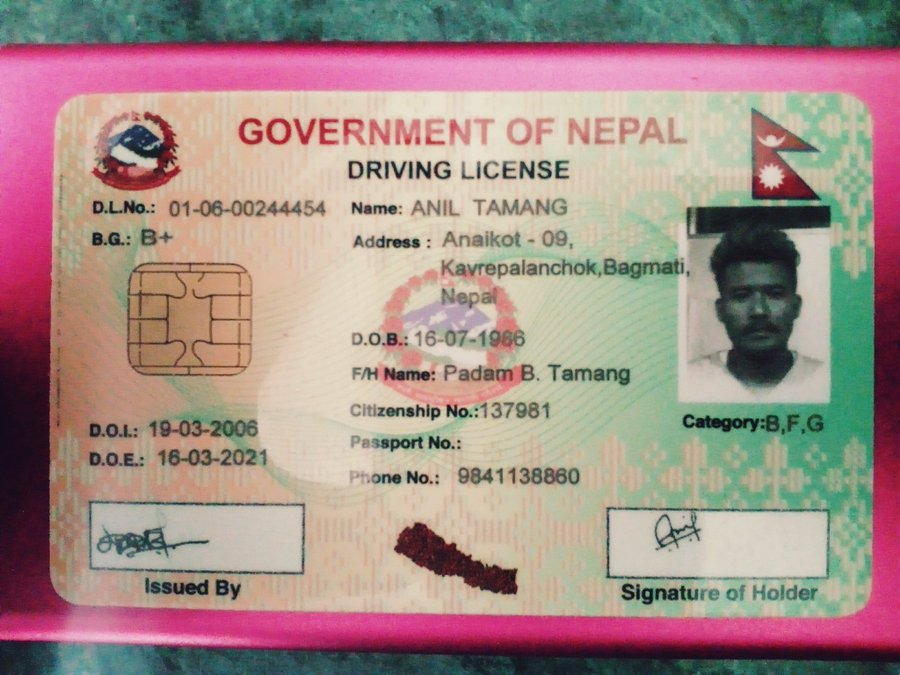

In [20]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("testing_data/images/3.jpg")
image = image.convert("RGB")
image

In [21]:
inference_dataset = OcrDataset(image_file_names=["3.jpg"], tokenizer=tokenizer, max_length=512, target_size=224)

In [22]:
test_encoding = inference_dataset[0]
test_encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'resized_image', 'resized_and_aligned_bounding_boxes', 'unnormalized_token_boxes'])

In [23]:
for k,v in test_encoding.items():
  test_encoding[k] = test_encoding[k].unsqueeze(0).to(device)

input_ids=test_encoding['input_ids']
bbox=test_encoding['bbox']
attention_mask=test_encoding['attention_mask']
token_type_ids=test_encoding['token_type_ids']
labels=test_encoding['labels']
resized_images = test_encoding['resized_image']
resized_and_aligned_bounding_boxes = test_encoding['resized_and_aligned_bounding_boxes']

In [24]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids, 
                labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)

In [25]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level
token_actual_boxes = test_encoding['unnormalized_token_boxes'].squeeze().tolist()

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    word_level_predictions.append(token_pred)
    final_boxes.append(box)

print(word_level_predictions)
print(final_boxes)

[6, 7, 7, 6, 7, 5, 5, 5, 5, 5, 5, 5, 5, 0, 1, 1, 1, 6, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 6, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 6, 7, 6, 7, 7]
[[233, 111, 690, 153], [233, 111, 690, 153], [233, 111, 690, 153], [344, 156, 574, 186], [344, 156, 574, 186], [88, 194, 330, 220], [88, 194, 330, 220], [88, 194, 330, 220], [88, 194, 330, 220], [88, 194, 330, 220], [88, 194, 330, 220], [88, 194, 330, 220], [88, 194, 330, 220], [349, 196, 462, 220], [349, 196, 462, 220], [349, 196, 462, 220], [470, 194, 570, 220], [88, 224, 176, 250], [88, 224, 176, 250], [88, 224, 176, 250], [88, 224, 176, 250], [88, 224, 176, 250], [88, 224, 176, 250], [353, 233, 423, 251], [440, 228, 526, 252], [538, 226, 572, 250], [435, 253, 690, 283], [435, 253, 690, 283], [435, 253, 690, 283], [435, 253, 690, 283], [438, 284, 496, 310], [348, 326, 528, 350], [348, 326, 528, 350], [348

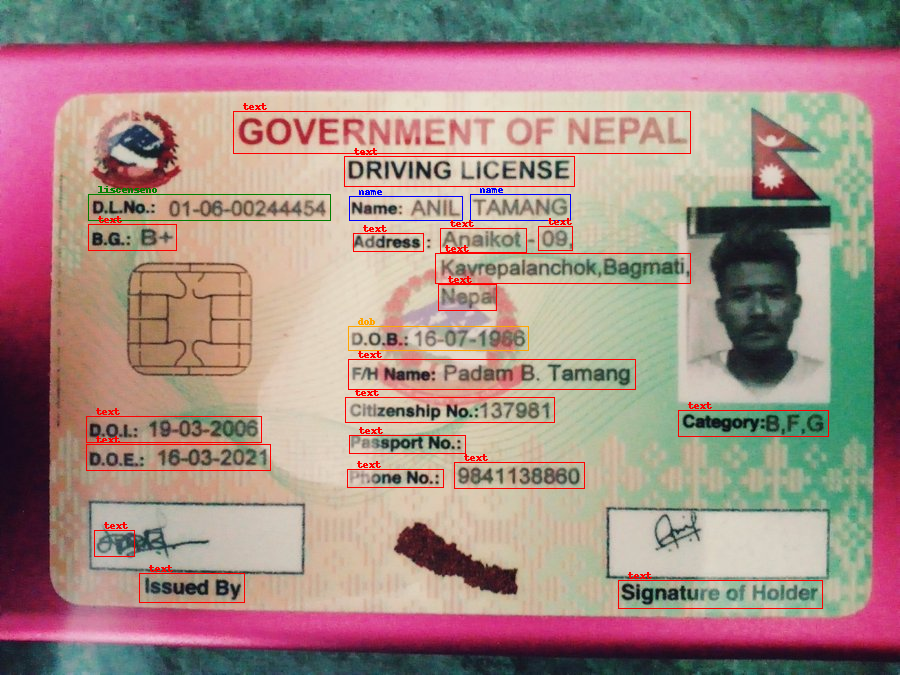

In [26]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    return label[2:]

label2color = {'name':'blue', 'liscenseno':'green', 'dob':'orange', 'text': 'red'}

for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(idx2label[prediction]).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image